# Обычный метод наименьших квадратов (OLS), исследовательская регрессия, географически взвешенная регрессия (GWR)

In [59]:
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot
import seaborn as sns
import matplotlib.pyplot as plt
from libpysal import weights

## Цель

Выявить факторы влияющие на высокие среднемесячные доходы

 - 1. Исследовательская регрессия
 - 2. Обычный метод наименьших квадратов (OLS)
 - 3. Географически взвешенная регрессия (GWR)

 **Моделируемая зависимая переменная:**
    - Income (Средний месячный доход на душу населения в рублях)

**10 независимых переменных:**
   - popul (Общая численность населения)
   - area (Площадь района)
   - Density (Плотность населения (человек на квадратный метр))
   - University (Доля (%) населения с высшим образованием)
   - Rent (Среднемесячная арендная плата (в евро))
   - mean_age (Средний возраст домов)
   - work_near (Доля (%) населения имеющее работу в шаговй доступности)
   - food_varie (Индекс разнообразия общ. питания (цена/категория/время))
   - area_per (Общая площадь жилых помещений, приходящаяся в среднем на одного жителя)
   - shop_count (количество магазинов на душу населения) 

## Данные

In [60]:
city_gdf = gpd.read_file("msk_dist.geojson")\

city_gdf.head(1)

,fid,name_ao,name_dist,popul,area,Density,University,Income,Rent,mean_age,work_near,food_varie,area_per,shop_count,geometry
0,119.0,ЗАО,Можайский,142052,16916489,8397,29,71.91,217873,41.83,0.24,94,19.28,1.91,"MULTIPOLYGON (((398820.607 6173500.149, 398820..."


## Исследовательская регрессия

Ищем лучшие модели

In [61]:
%%time

import statsmodels.api as sm
import statsmodels.stats.api as sms
from itertools import combinations
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from esda.moran import Moran

all_data = []
line_param = []
id_model = 0
  
y = city_gdf['Income']

A = ['Density', 
     'University',  
     'Rent', 
     'mean_age', 
     'work_near', 
     'food_varie',
     'area_per', 
     'shop_count']

w = Queen.from_dataframe(city_gdf)
w.transform = 'r'


for prd in range(1,5):
    
#    print(prd)
    
    temp = combinations(A, prd)

    for i in list(temp):
#        print (i)
        
        id_model += 1

        x = city_gdf[list(i)]

        #add constant to predictor variables
        x = sm.add_constant(x)
        #fit linear regression model
        model = sm.OLS(y, x).fit()

        line_param.append(id_model)
        line_param.append(prd)
        line_param.append(list(i))

        
        #R2-скорректированный
        line_param.append(round((model.rsquared_adj),2))
        
        #AIC
        line_param.append(round((model.aic),2))
        
        #studentized Breusch-Pagan statistic
        test_result = sms.het_breuschpagan(model.resid, model.model.exog)
        # критерий  Бреуша-Пагана-Лагранжа на гетероскедастичность
        test_result[0]
        #p-value критерия
        line_param.append(round((test_result[1]),3))
        
        #Статистика Жака-Бера
        sms.jarque_bera(model.resid)[0]
        # p-value  Жака-Бера
        line_param.append(round((sms.jarque_bera(model.resid)[1]),3))
        
        #VIF
        line_param.append(round(max([vif(x.values, i) for i in range(x.shape[1])][1:]),3))
        
        #Индекс I Морана
        y_IM = model.resid.values
        moran = Moran(y_IM, w)
        line_param.append(round((moran.p_norm),3))
        
        all_data.append(line_param)
        
        line_param = []
        
    
df = pd.DataFrame(data=all_data, columns = ['id_model', 
                                            'cnt_predicts', 
                                            'name_predicts', 
                                            'Radj', 
                                            'AIC',
                                            'pBP',
                                            'pJB', 
                                            'VIF', 
                                            'pMoran'])



df["RANK"] = df.groupby("cnt_predicts")["Radj"].rank(method="first", ascending=False)\


final_models = df\
    .sort_values(['cnt_predicts', 'Radj'], ascending = [True, False])\
    .query('RANK <=3')\


final_models.head(15)

Wall time: 5.55 s


,id_model,cnt_predicts,name_predicts,Radj,AIC,pBP,pJB,VIF,pMoran,RANK
1,2,1,[University],0.68,498.49,0.771,0.288,1.000,0.0,1.0
2,3,1,[Rent],0.57,529.09,0.001,0.574,1.000,0.0,2.0
5,6,1,[food_varie],0.51,544.30,0.339,0.045,1.000,0.0,3.0
15,16,2,"[University, Rent]",0.75,470.69,0.807,0.405,1.813,0.0,1.0
17,18,2,"[University, work_near]",0.74,478.05,0.426,0.895,1.334,0.0,2.0
18,19,2,"[University, food_varie]",0.72,485.00,0.776,0.203,1.878,0.0,3.0
58,59,3,"[University, Rent, work_near]",0.79,457.18,0.627,0.665,1.943,0.0,1.0
59,60,3,"[University, Rent, food_varie]",0.76,468.71,0.671,0.211,2.334,0.0,2.0
36,37,3,"[Density, University, Rent]",0.75,472.69,0.606,0.397,1.844,0.0,3.0
131,132,4,"[University, Rent, work_near, food_varie]",0.79,457.92,0.431,0.579,2.496,0.0,1.0


 **Вывод:** В этом разделе представлены 3 лучшие модели, включающие от одной до 4 независимых переменных. Многие модели имеют высокое значение скорректированного R-квадрата (>0.8). Мультиколлинеарность не является проблемой для вышеупомянутых моделей, так как во всех случаях значение VIF меньше 4. Также можно заметить что многие модели соответствуют нормальному распределению ошибок (pJB < 0.05) и гомоскедастичности (pBP < 0.05). Во всех моделях присутствует статистически значимая пространственная автокорреляция (pMoran < 0.05);
 
  **Лучшая модель:** [University, Rent, work_near] - у неё высокий скорректированный R-квадрат (0.79) и минимальный критерий AIC (457);

## Обычный метод наименьших квадратов (OLS)

### Распределение значений переменных и отношение между ними

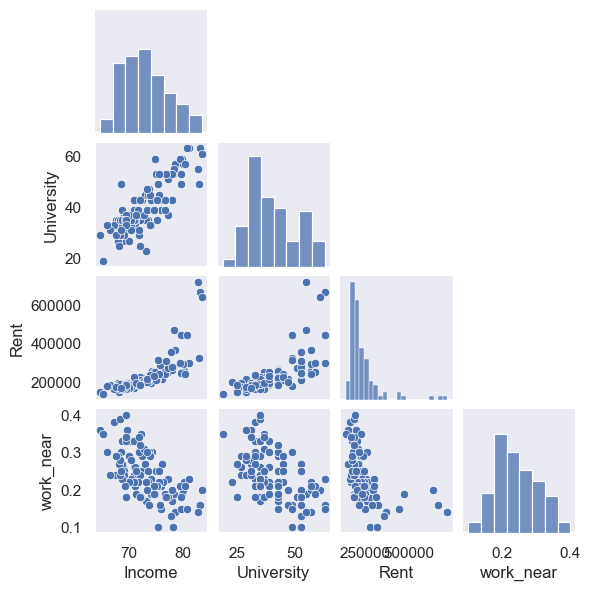

In [62]:
sns.set_theme(style="dark")
 
city_pd_pred = city_gdf[['Income','University', 'Rent', 'work_near']]

sns.pairplot(city_pd_pred, height = 1.5, corner = True)

plt.show()

 **Вывод:** Поле Rent имеет выбросы в высоких значениях, их следует преобразовать

### Преобразование данных

In [63]:
import numpy as np
from sklearn.preprocessing import PowerTransformer

power = PowerTransformer(method='box-cox', standardize=True)

x = city_gdf[['Rent']]

#transform 
data_trans = power.fit_transform(x)

city_gdf['Rent'] = data_trans

In [64]:
import seaborn as sns
sns.set_theme(style="darkgrid")

tips = sns.load_dataset("tips")
g = sns.jointplot(x="Income", y="Rent", data=city_gdf,
                  kind="reg", truncate=False,
                  color="m", height=4)

 **Вывод:** Применение преобразования Box-Cox исправила выбросы, теперь распределение стало значительно лучше и его можно дальше использовать в модели OLS

### Модель

In [65]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.preprocessing import MinMaxScaler

y = city_gdf['Income']
x = city_gdf[['University', 'Rent', 'work_near']]

#transform 
scaler = MinMaxScaler(feature_range=(0,1))

x=pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

In [66]:
#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     200.3
Date:                Sun, 18 Jun 2023   Prob (F-statistic):           7.81e-43
Time:                        17:11:34   Log-Likelihood:                -205.74
No. Observations:                 107   AIC:                             419.5
Df Residuals:                     103   BIC:                             430.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.4171      0.996     63.687      0.0

### Карта стандартизированных остатков

In [67]:
from matplotlib.colors import ListedColormap, BoundaryNorm

bounds = np.array([-3, -2, -1, 0, 1,2,3])
norm = BoundaryNorm(boundaries=bounds, ncolors=256)
cbar = plt.cm.ScalarMappable(norm=norm, cmap='RdBu_r')

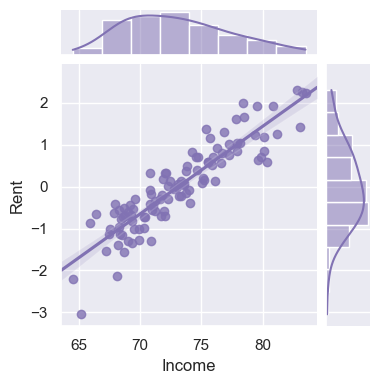

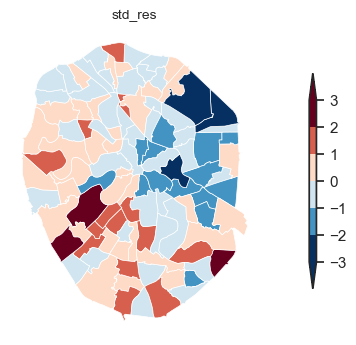

In [68]:
sns.set_theme(style="white")

fig, ax = plt.subplots(figsize=(13, 4))

city_gdf['std_res'] = model.resid_pearson

city_gdf.plot(column="std_res", 
              norm=norm,
              linewidth=.5, 
              cmap='RdBu_r',
              ax = ax)

ax.set_title("std_res", fontsize=10)
ax.set_axis_off()

fig.colorbar(cbar, 
             ax=ax, 
             shrink = 0.7, 
             aspect = 30,  
             extend="both",
            extendfrac='auto')


ax.set_title("std_res", fontsize=10)
ax.set_axis_off()

# Remove all borders
sns.despine(bottom = True, left = True)
plt.show()


## Выводы:

### Общая значимость/ качество модели

#### R-квадрат

In [69]:
model.rsquared

0.8536686629998733

**Интерпретация:** Модель объясняет 85,3% дисперсии переменной Expenses;

**Примечания:** Следует также проверить скорректированный R-квадрат, чтобы избежать переобучения модели. Скорректированный R-квадрат предпочтительнее, особенно когда их разница велика;

**Оценка:** <span style='color:green'>хорошо</span>

#### Скорректированный R-квадрат 

In [70]:
model.rsquared_adj

0.8494065852231706

**Интерпретация:** Скорректированный R-квадрат равен 0,849, что указывает на высокое качество модели;

**Примечания:** В случае низкого качества модели в нее следует включить дополнительные переменные или использовать другие виды регрессии (например, модель пространственного лага);

**Оценка:** <span style='color:green'>хорошо</span>

#### F-статистика (совместная F-статистика)

In [71]:
#значение критерия
model.fvalue

200.29401332518603

In [72]:
#p-value критерия  (p-value меньше 0.05 это значит что критерий значим)
model.f_pvalue

7.811342755095838e-43

**Интерпретация:** Мы отвергаем нулевую гипотезу и принимаем гипотезу о статистической значимости регрессионной модели. Наблюдаемая тенденция действительно существует и не является результатом случайной выборки из генеральной совокупности;

**Оценка:** <span style='color:green'>хорошо</span>

#### Критерий Вальда  (Joint Wald Statistic)

In [73]:
model.wald_test_terms()

C:\Users\Artyom\anaconda3\lib\site-packages\statsmodels\base\model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


<class 'statsmodels.stats.contrast.WaldTestResults'>
                                F                     P>F  df constraint  df denom
const       [[4055.982240771511]]  1.5243723714679503e-84              1     103.0
University  [[19.59396994734386]]   2.388017451097613e-05              1     103.0
Rent        [[78.41195714754826]]   2.577245758622573e-14              1     103.0
work_near   [[4.952937659743277]]    0.028226117131795393              1     103.0

**Интерпретация:** Поскольку критерий Вальда для всех предикторов статистически значим, он указывает на общую значимость модели;

**Примечания:** Критерий Вальда используется для оценки общего качества модели, особенно когда статистика Кенкера (ВР) статистически значима (p < 0,05);

**Оценка:** <span style='color:green'>хорошо</span>

#### Информационный критерий Акаике (AlC)

In [74]:
model.aic

419.4869091325746

**Интерпретация:** Используется для сравнения пространственных моделей. Чем меньше значение AIC, тем выше качество модели;

**Примечания:** AIC - это показатель качества моделей, полученных на одном и том же наборе данных. Используется для сравнения разных моделей и выбора наиболее подходящей;

### Гетероскедастичность

#### Диаграмма остатков и вычисленных значений

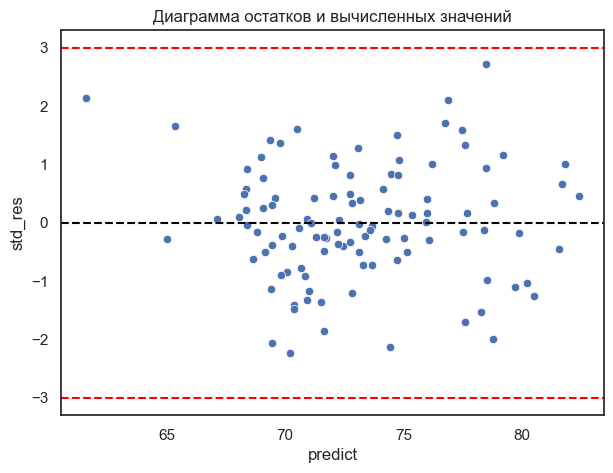

In [75]:
fig, ax = plt.subplots(figsize=(7,5))

city_gdf['predict'] = model.predict()

sns.scatterplot(data=city_gdf,x = 'predict', y="std_res", ax=ax)

plt.axhline(y=3, color="red", linestyle="--")
plt.axhline(y=0, color="black", linestyle="--")
plt.axhline(y=-3, color="red", linestyle="--")

plt.title('Диаграмма остатков и вычисленных значений')

plt.show()

**Интерпретация:**  Не одно значение не превысило 3 стандартных отклонений. Присутствуют влиятельные наблюдения (большое плечо) при низких вычисленных значениях.

#### Критерий Кенкера (BP)

In [76]:
#studentized Breusch-Pagan statistic
test_result = sms.het_breuschpagan(model.resid, model.model.exog)

In [77]:
# критерий Бреуша-Пагана-Лагранжа на гетероскедастичность
test_result[0]

2.3465770557439827

In [78]:
#p-value критерия
test_result[1]

0.5036567482250831

**Интерпретация:** p-value не меньше 0.05, мы не можем отвергнуть нулевую гипотезу. У нас нет достаточных доказательств того, что в регрессионной модели присутствует гетероскедастичность.

**Примечания:** Если значение критерия статистически не значимо, то отношения, моделируемые с помощью коэффициентов, однородны.

**Оценка:** <span style='color:green'>Хорошо</span>

### Коэффициенты

#### t-статистика

In [79]:
model.pvalues

const         1.524372e-84
University    2.388017e-05
Rent          2.577246e-14
work_near     2.822612e-02
dtype: float64

**Интерпретация:** Переменные значимы на уровне значимости (p-value < 0.05), все переменные важны;


**Оценка:** <span style='color:green'>хорошо</span>

### Мультиколлинеарность

#### Фактор инфляционной дисперсии (VIF)

In [80]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

vif_pd = pd.DataFrame()
vif_pd["VIF Factor"] = [vif(x.values, i) for i in range(x.shape[1])]
vif_pd["features"] = x.columns

vif_pd

,VIF Factor,features
0,37.279891,const
1,2.804726,University
2,3.393061,Rent
3,1.614453,work_near


**Интерпретация:** Значение VIF для всех переменных меньше 4. Мультиколлинеарность отсутствует. (VIF = 1-4: коллинеарность отсутствует; VIF= 4-10: необходим дальнейший анализ; VIF > 10: сильная коллинеарность);;

**Оценка:** <span style='color:green'>хорошо</span>

### Нормальность распределения остатков

#### Гистограмма стандартизированных остатков

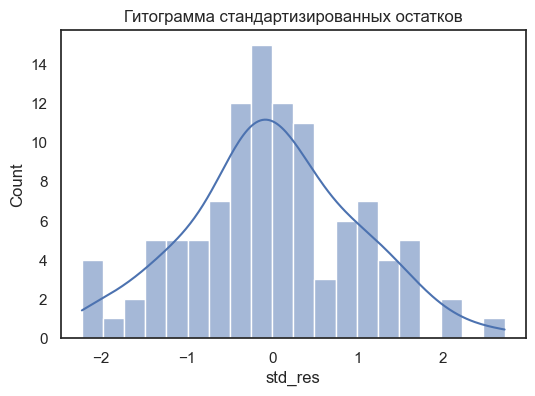

In [81]:
fig, ax = plt.subplots(figsize=(6,4))

sns.histplot(data=city_gdf, x="std_res", ax=ax, kde=True, bins = 20)

plt.title('Гитограмма стандартизированных остатков')

plt.show()

#### Критерий Жака-Бера

In [82]:
#Статистика Жака-Бера
sms.jarque_bera(model.resid)[0]

0.07322793597615909

In [83]:
# p-value  Жака-Бера
sms.jarque_bera(model.resid)[1]

0.9640482169995154

**Интерпретация:** Мы принимаем нулевую гипотезу (о нормальном распределении ошибок), потому что значение критерия статистически значимо (p-value больше 0.05);

**Оценка:** <span style='color:green'>Хорошо</span>

### Пространственная автокорреляция

#### Индекс Морана I

In [84]:
from esda.moran import Moran

y = city_gdf['std_res'].values

w = Queen.from_dataframe(city_gdf)
w.transform = 'r'

In [85]:
moran = Moran(y, w)
moran.I

0.3427359579149119

In [86]:
moran.p_norm

1.6238974609450452e-09

**Вывод:** p-value меньше 0.05 это значит что присутствует пространственная автокорреляция

**Интерпретация:** Мы отвергаем нулевую гипотезу (p-value < 0.05), в распределении остатков наблюдается пространственная автокорреляция;

### Общее заключение по модели OLS

**Вывод:** В модели присутствует пространственная автокорреляция в распределении остатков.

**Следующий шаг:** Попробовать применить географически взвешенную регрессию (GWR)

## Географически взвешенная регрессия (GWR)

 ***Географически взвешенная регрессия (GWR)*** - это локальная форма модели линейной регрессии, используемая для обнаружения неоднородности и анализа пространственно изменяющихся отношений. Географически взвешенная регрессия предоставляет локальную модель зависимой переменной, в которой коэффициенты могут изменяться в пространстве путем подгонки взвешенной модели линейной регрессии к каждому пространственному объекту в наборе данных. Географически взвешенная регрессия основывается на тех же предположениях, что и множественная линейная регрессия.

In [87]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [88]:
#Prepare  dataset inputs
g_y = city_gdf['Income'].values.reshape((-1,1))
g_X = city_gdf[['University', 'Rent', 'work_near']].values
u = city_gdf.centroid.x
v = city_gdf.centroid.y
g_coords = list(zip(u,v))

#z-оценка предикторов
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

#z-оценка таргета
#g_y = g_y.reshape((-1,1))
#g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [89]:
#Calibrate GWR model

#Instantiate bandwidth selection object
gwr_selector = Sel_BW(g_coords, g_y, g_X, fixed=False)

#Default golden section search using AICc criterion
gwr_bw = gwr_selector.search(criterion='AICc')

gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

In [90]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 107
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            293.132
Log-likelihood:                                                    -205.743
AIC:                                                                419.487
AICc:                                                               422.081
BIC:                                                               -188.169
R2:                                                                   0.854
Adj. R2:                                                              0.849

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

## Качество модели GWR

### Картирование стандартизированных остатков

In [91]:
city_gdf['predict_GWR'] = gwr_results.predy
city_gdf['std_res_GWR'] = gwr_results.std_res

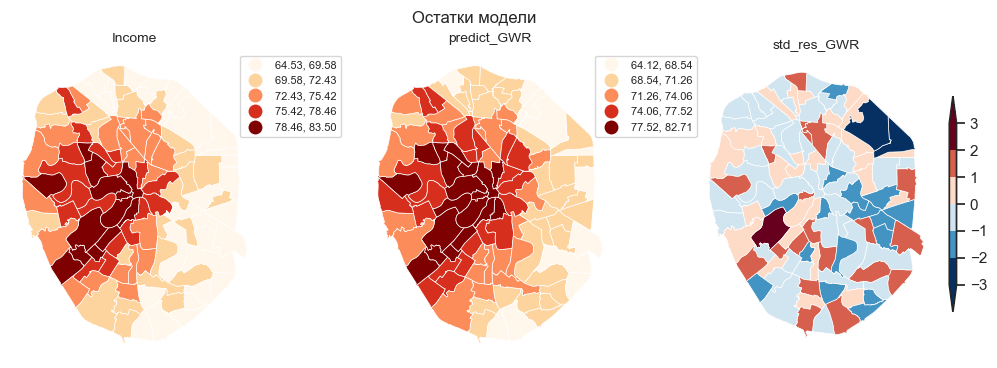

In [92]:
sns.set_theme(style="white")

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

fig.suptitle("Остатки модели", fontsize=12)

city_gdf.plot(column="Income", 
              scheme='NaturalBreaks', 
              k=5, 
              linewidth=.5, 
              cmap='OrRd', 
              legend=True,
              legend_kwds={"loc": "lower left", 
                           "bbox_to_anchor": (0.9, 0.7), 
                           "fontsize":"8"},
              ax = axs[0])


axs[0].set_title("Income", fontsize=10)
axs[0].set_axis_off()

city_gdf.plot(column="predict_GWR", 
              scheme='NaturalBreaks', 
              k=5, 
              linewidth=.5, 
              cmap='OrRd', 
              legend=True,
              legend_kwds={"loc": "lower left", 
                           "bbox_to_anchor": (0.9, 0.7), 
                           "fontsize":"8"},
              ax = axs[1])

axs[1].set_title("predict_GWR", fontsize=10)
axs[1].set_axis_off()

city_gdf.plot(column="std_res_GWR", 
              norm=norm,
              linewidth=.5, 
              cmap='RdBu_r',
              ax = axs[2])

axs[2].set_title("std_res_GWR", fontsize=10)
axs[2].set_axis_off()

fig.colorbar(cbar, 
             ax=axs[2], 
             shrink = 0.7, 
             aspect = 30,  
             extend="both",
            extendfrac='auto')


# Remove all borders
sns.despine(bottom = True, left = True)
plt.show()

**Интерпретация:** Наблюдается случайный порядок распределения ошибок (std_res_GWR);

### Диаграмма остатков и вычисленных значений

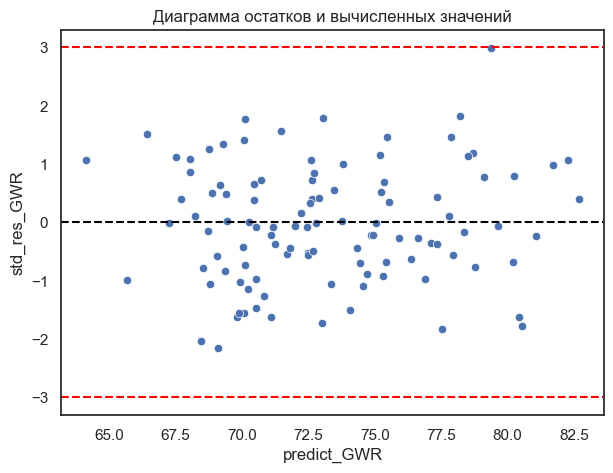

In [93]:
fig, ax = plt.subplots(figsize=(7,5))

sns.scatterplot(data=city_gdf,x = 'predict_GWR', y="std_res_GWR", ax=ax)

plt.axhline(y=3, color="red", linestyle="--")
plt.axhline(y=0, color="black", linestyle="--")
plt.axhline(y=-3, color="red", linestyle="--")

plt.title('Диаграмма остатков и вычисленных значений')

plt.show()



**Интерпретация:** Не одно значение не превысило 3 стандартных отклонений. В целом диаграмма рассеяния свидетельствует о наличии гомоскедастичности;

### Индекс Морана I

In [94]:
from esda.moran import Moran

y = city_gdf['std_res_GWR'].values

w = Queen.from_dataframe(city_gdf)
w.transform = 'r'

In [95]:
moran_gwr = Moran(y, w)
moran_gwr.I

0.014272492250005347

In [96]:
moran_gwr.z_norm

0.4060164390174953

In [97]:
moran_gwr.p_norm

0.6847305216969524

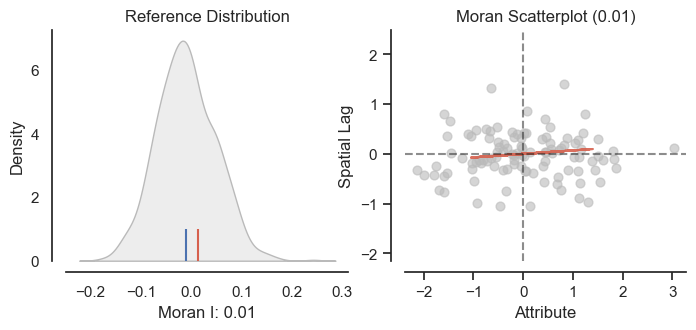

In [98]:
from splot.esda import plot_moran

plot_moran(moran_gwr, zstandard=True, figsize=(8,3))
plt.show()

**Интерпретация:** Индекс I Морана равен **0.01**, значения распределены случайным образом, автокорреляции практически не наблюдается. Мы не можем отвергнуть нулевую гипотезу (p-value > 0.5) об отсутствии закономерности. Это признак высокой эффективности модели GWR.

### Картирование локальных коэффициентов

In [99]:
city_gdf['pram_University'] = gwr_results.params[:,1]
city_gdf['pram_Rent'] = gwr_results.params[:,2]
city_gdf['pram_work_near'] = gwr_results.params[:,3]

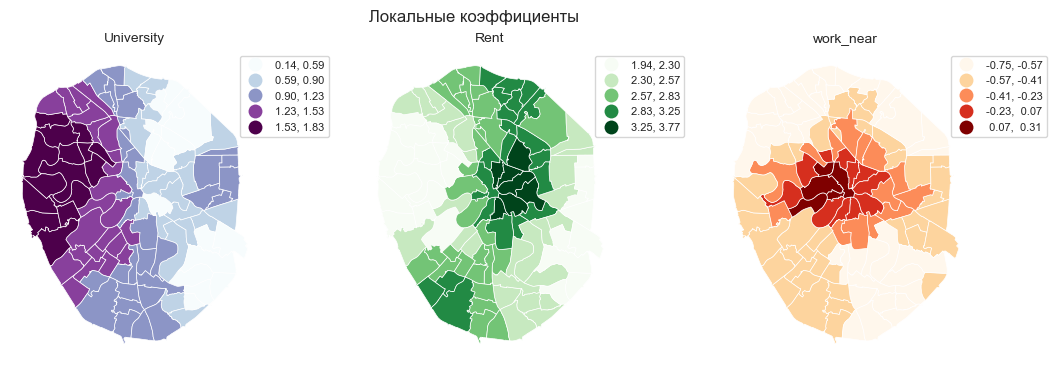

In [100]:
sns.set_theme(style="white")

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

fig.suptitle("Локальные коэффициенты", fontsize=12)

city_gdf.plot(column="pram_University", 
              scheme='NaturalBreaks', 
              k=5, 
              linewidth=.5, 
              cmap='BuPu', 
              legend=True,
              legend_kwds={"loc": "lower left", 
                           "bbox_to_anchor": (0.9, 0.7), 
                           "fontsize":"8"},
              ax = axs[0])

axs[0].set_title("University", fontsize=10)
axs[0].set_axis_off()

city_gdf.plot(column="pram_Rent", 
              scheme='NaturalBreaks', 
              k=5, 
              linewidth=.5, 
              cmap='Greens', 
              legend=True,
              legend_kwds={"loc": "lower left", 
                           "bbox_to_anchor": (0.9, 0.7), 
                           "fontsize":"8"},
              ax = axs[1])

axs[1].set_title("Rent", fontsize=10)
axs[1].set_axis_off()

city_gdf.plot(column="pram_work_near", 
              scheme='NaturalBreaks', 
              k=5, 
              linewidth=.5, 
              cmap='OrRd',
              legend=True,
              legend_kwds={"loc": "lower left", 
                           "bbox_to_anchor": (0.9, 0.7), 
                           "fontsize":"8"},
              ax = axs[2])

axs[2].set_title("work_near", fontsize=10)
axs[2].set_axis_off()

# Remove all borders
sns.despine(bottom = True, left = True)
plt.show()

**Интерпретация:** 

 - *University* - картирование коэффициентов помогло выявить тенденденцию в направлении с востока на запад города;

 - *Rent* - тенденция наблюдается в центре города, а также в северных и юго-западных частях;

 - *work_near* -  тенденция наблюдается в центре города, а также в северных и юго-западных частях;

### Ширина полосы и количество соседей

In [101]:
## модель GWR
gwr_bw

50.0

**Значение OLS:** Несравнимо непосредственно. В OLS используются все пространственные объекты (107);

**Интерпретация:** Для получения каждой локальной оценки используется 50 из 107 пространственных объектов. В каждом ядре используется примерно 47% данных;

### Сумма квадратов остатков

In [102]:
## модель OLS
model.ssr

293.13223348211307

In [103]:
## модель GWR
gwr_results.resid_ss

154.3245278559528

**Интерпретация:** Локальная модель имеет меньшую сумму квадратов остатков, что говорит о её более высоком качестве.

###  Эффективно число параметров

In [104]:
## модель GWR
gwr_results.ENP

18.441756514510512

**Интерпретация:** Эффективное число параметров для этого набора данных может колебаться от 4 до 107. Значение 18.44 близко к 4, что указывает на тенденцию локальной модели к глобальной;

### Скорректированный информационный критерий Акаике (AICc)

In [105]:
## модель OLS
model.aic

419.4869091325746

In [106]:
## модель GWR
gwr_results.aicc

390.9056517858499

**Интерпретация:** Значение коэффициентов отличаются больше чем на 3. Это говорит о её более высоком качестве.

#### R-квадрат

In [107]:
## модель OLS
model.rsquared

0.8536686629998733

In [108]:
## модель GWR
gwr_results.R2

0.9229613399221999

**Интерпретация:** Значение для локальной модели выше, чем для глобальной. Модель GWR объясняет 92.2% дисперсии переменной Income

#### Скорректированный R-квадрат 

In [109]:
## модель OLS
model.rsquared_adj

0.8494065852231706

In [110]:
gwr_results.adj_D2

0.9067352468120248

**Интерпретация:** Скорректированный R-квадрат равен 0,907, что указывает на высокое качество модели;

## Общее заключение по модели GWR

В целом локальная модель GWR работает лучше глобальной модели OLS, давая богатые возможности визуализации, которые помогают выявлять различные пространственные отношения. Пространственная автокорреляция отсутствует в остатках, модели демонстрируют высокую степень согласованности и отсутствие проблем с мультиколлинеарностью. Путем сопоставления оценок коэффициентов обнаруживаются тенденции, которые могут послужить ценными признаками внутренних процессов. GWR лучше работает с большими наборами данных (более 160 пространственных единиц), чем с текущим слоем.